<a href="https://colab.research.google.com/github/kulight/fpt_clusttering/blob/master/encoder_clustering_fpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
np.random.seed(4881)
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Reshape,Input
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
tf.random.set_seed(4881)


import time

pd.options.display.max_columns = None
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
gpath = '/content/drive/My Drive/datasets/'
fpt = pd.read_csv(f'{gpath}five_p_eda.csv')

In [4]:
fpt = fpt.sample(n=20000, random_state=888)
fpt.shape

(20000, 56)

In [5]:
fpt = fpt.drop('cred_score', axis=1)
fpt.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EXT,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,EST,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,AGR,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,CSN,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,OPN
443270,1.0,2.0,4.0,2.0,4.0,3.0,2.0,1.0,3.0,2.0,24.0,1.0,3.0,4.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,16.0,1.0,3.0,5.0,4.0,4.0,5.0,5.0,2.0,4.0,4.0,37.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,47.0,3.0,4.0,4.0,4.0,4.0,5.0,4.0,3.0,4.0,4.0,39.0
108441,2.0,3.0,5.0,4.0,3.0,4.0,5.0,3.0,4.0,3.0,36.0,4.0,3.0,5.0,4.0,2.0,3.0,4.0,1.0,1.0,1.0,28.0,1.0,5.0,5.0,5.0,3.0,5.0,5.0,4.0,5.0,5.0,43.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,3.0,5.0,3.0,41.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0,37.0
37125,5.0,3.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0,3.0,41.0,1.0,3.0,3.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,18.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,49.0,4.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,47.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,48.0
548588,3.0,3.0,4.0,3.0,3.0,5.0,2.0,3.0,2.0,1.0,29.0,4.0,3.0,5.0,4.0,4.0,4.0,3.0,3.0,2.0,4.0,36.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,49.0,1.0,2.0,5.0,1.0,1.0,1.0,2.0,3.0,1.0,3.0,20.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,3.0,5.0,5.0,47.0
485785,1.0,2.0,2.0,2.0,2.0,4.0,2.0,2.0,2.0,2.0,21.0,2.0,2.0,4.0,2.0,2.0,1.0,1.0,2.0,4.0,1.0,21.0,1.0,5.0,3.0,4.0,4.0,2.0,4.0,4.0,2.0,3.0,32.0,5.0,5.0,4.0,4.0,3.0,5.0,5.0,3.0,5.0,5.0,44.0,3.0,5.0,2.0,5.0,4.0,1.0,5.0,4.0,4.0,3.0,36.0


In [6]:
fpt.shape

(20000, 55)

## Scaling all columns btween 0 and 1.

In [7]:
quests = ['EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7', 'EXT8', 'EXT9', 'EXT10',
         'EST1', 'EST2', 'EST3', 'EST4', 'EST5', 'EST6', 'EST7', 'EST8', 'EST9', 'EST10',
         'AGR1', 'AGR2', 'AGR3', 'AGR4', 'AGR5', 'AGR6', 'AGR7', 'AGR8', 'AGR9', 'AGR10',
         'CSN1', 'CSN2', 'CSN3', 'CSN4', 'CSN5', 'CSN6', 'CSN7', 'CSN8', 'CSN9', 'CSN10', 
         'OPN1', 'OPN2', 'OPN3', 'OPN4', 'OPN5', 'OPN6', 'OPN7', 'OPN8', 'OPN9', 'OPN10']

trait_sums = ['EXT', 'EST','AGR','CSN','OPN']

q_fpt = fpt[quests] / 5.0
q_fpt[trait_sums]= fpt[trait_sums] / 50

q_fpt.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,EXT,EST,AGR,CSN,OPN
443270,0.2,0.4,0.8,0.4,0.8,0.6,0.4,0.2,0.6,0.4,0.2,0.6,0.8,0.2,0.4,0.2,0.2,0.2,0.2,0.2,0.2,0.6,1.0,0.8,0.8,1.0,1.0,0.4,0.8,0.8,0.8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.8,0.8,0.6,0.8,0.8,0.8,0.8,1.0,0.8,0.6,0.8,0.8,0.48,0.32,0.74,0.94,0.78
108441,0.4,0.6,1.0,0.8,0.6,0.8,1.0,0.6,0.8,0.6,0.8,0.6,1.0,0.8,0.4,0.6,0.8,0.2,0.2,0.2,0.2,1.0,1.0,1.0,0.6,1.0,1.0,0.8,1.0,1.0,0.8,0.8,0.8,0.8,1.0,0.8,1.0,0.6,1.0,0.6,0.6,0.8,0.8,0.8,0.8,0.8,0.8,0.4,0.8,0.8,0.72,0.56,0.86,0.82,0.74
37125,1.0,0.6,1.0,0.8,0.8,1.0,0.8,0.8,0.8,0.6,0.2,0.6,0.6,0.2,0.4,0.2,0.4,0.4,0.2,0.4,1.0,0.8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.8,1.0,0.8,1.0,1.0,0.8,1.0,1.0,1.0,1.0,1.0,1.0,0.8,1.0,1.0,1.0,1.0,1.0,0.8,1.0,0.82,0.36,0.98,0.94,0.96
548588,0.6,0.6,0.8,0.6,0.6,1.0,0.4,0.6,0.4,0.2,0.8,0.6,1.0,0.8,0.8,0.8,0.6,0.6,0.4,0.8,1.0,1.0,0.8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,0.4,1.0,0.2,0.2,0.2,0.4,0.6,0.2,0.6,1.0,1.0,1.0,1.0,0.8,1.0,1.0,0.6,1.0,1.0,0.58,0.72,0.98,0.40,0.94
485785,0.2,0.4,0.4,0.4,0.4,0.8,0.4,0.4,0.4,0.4,0.4,0.4,0.8,0.4,0.4,0.2,0.2,0.4,0.8,0.2,0.2,1.0,0.6,0.8,0.8,0.4,0.8,0.8,0.4,0.6,1.0,1.0,0.8,0.8,0.6,1.0,1.0,0.6,1.0,1.0,0.6,1.0,0.4,1.0,0.8,0.2,1.0,0.8,0.8,0.6,0.42,0.42,0.64,0.88,0.72


## creating df for all clustering methods.
'clust_fpt' will be used to aggregate and compare different cluster analyses.

In [8]:
clust_fpt = q_fpt

# Autoencoder

In [9]:
X_train = q_fpt

In [10]:
cols = 55

### Defining and compiling the autoencoder model

In [11]:
encoder = Sequential()
encoder.add(Dense(32, input_shape=[cols], activation="relu"))
encoder.add(Dense(16, activation="relu"))
encoder.add(Dense(3,activation="relu"))

decoder = Sequential()
decoder.add(Dense(16, input_shape=[3], activation='relu'))
decoder.add(Dense(32, activation='relu'))
decoder.add(Dense(cols, activation="relu"))

autoencoder = Sequential([encoder,decoder])
autoencoder.compile(loss="mse")

In [12]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 3)                 2371      
_________________________________________________________________
sequential_1 (Sequential)    (None, 55)                2423      
Total params: 4,794
Trainable params: 4,794
Non-trainable params: 0
_________________________________________________________________


### Training autoencoder model

In [13]:
autoencoder.fit(X_train, X_train, epochs=100, validation_data=(X_train, X_train))

Epoch 1/100
625/625 [==============================] - 2s 3ms/step - loss: 0.1932 - val_loss: 0.1803
Epoch 2/100
625/625 [==============================] - 2s 2ms/step - loss: 0.1800 - val_loss: 0.1796
Epoch 3/100
625/625 [==============================] - 1s 2ms/step - loss: 0.1790 - val_loss: 0.1782
Epoch 4/100
625/625 [==============================] - 1s 2ms/step - loss: 0.1652 - val_loss: 0.1601
Epoch 5/100
625/625 [==============================] - 1s 2ms/step - loss: 0.1582 - val_loss: 0.1265
Epoch 6/100
625/625 [==============================] - 1s 2ms/step - loss: 0.1131 - val_loss: 0.1115
Epoch 7/100
625/625 [==============================] - 1s 2ms/step - loss: 0.1106 - val_loss: 0.1102
Epoch 8/100
625/625 [==============================] - 2s 2ms/step - loss: 0.1100 - val_loss: 0.1034
Epoch 9/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0799 - val_loss: 0.0772
Epoch 10/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0765 - val_lo

### Using the encoder from the trained autoencoder to reduce dimentionality.

In [14]:
encoded_features = encoder.predict(X_train)
enc_features = pd.DataFrame(encoded_features, columns = ['X1', 'X2','X3'], index=X_train.index.copy())

# Identifing anomalies by loss score:

## Using autoencoder on the data and caculating loss between orginal data and autoencoded data.

In [16]:
predicted = pd.DataFrame(autoencoder.predict(X_train),index=clust_fpt.index.copy(), columns=q_fpt.columns)
dist = np.linalg.norm(q_fpt - predicted, axis=-1)
clust_fpt['loss'] = dist

clust_fpt.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,EXT,EST,AGR,CSN,OPN,loss
443270,0.2,0.4,0.8,0.4,0.8,0.6,0.4,0.2,0.6,0.4,0.2,0.6,0.8,0.2,0.4,0.2,0.2,0.2,0.2,0.2,0.2,0.6,1.0,0.8,0.8,1.0,1.0,0.4,0.8,0.8,0.8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.8,0.8,0.6,0.8,0.8,0.8,0.8,1.0,0.8,0.6,0.8,0.8,0.48,0.32,0.74,0.94,0.78,1.439186
108441,0.4,0.6,1.0,0.8,0.6,0.8,1.0,0.6,0.8,0.6,0.8,0.6,1.0,0.8,0.4,0.6,0.8,0.2,0.2,0.2,0.2,1.0,1.0,1.0,0.6,1.0,1.0,0.8,1.0,1.0,0.8,0.8,0.8,0.8,1.0,0.8,1.0,0.6,1.0,0.6,0.6,0.8,0.8,0.8,0.8,0.8,0.8,0.4,0.8,0.8,0.72,0.56,0.86,0.82,0.74,1.558969
37125,1.0,0.6,1.0,0.8,0.8,1.0,0.8,0.8,0.8,0.6,0.2,0.6,0.6,0.2,0.4,0.2,0.4,0.4,0.2,0.4,1.0,0.8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.8,1.0,0.8,1.0,1.0,0.8,1.0,1.0,1.0,1.0,1.0,1.0,0.8,1.0,1.0,1.0,1.0,1.0,0.8,1.0,0.82,0.36,0.98,0.94,0.96,1.888530
548588,0.6,0.6,0.8,0.6,0.6,1.0,0.4,0.6,0.4,0.2,0.8,0.6,1.0,0.8,0.8,0.8,0.6,0.6,0.4,0.8,1.0,1.0,0.8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,0.4,1.0,0.2,0.2,0.2,0.4,0.6,0.2,0.6,1.0,1.0,1.0,1.0,0.8,1.0,1.0,0.6,1.0,1.0,0.58,0.72,0.98,0.40,0.94,1.711421
485785,0.2,0.4,0.4,0.4,0.4,0.8,0.4,0.4,0.4,0.4,0.4,0.4,0.8,0.4,0.4,0.2,0.2,0.4,0.8,0.2,0.2,1.0,0.6,0.8,0.8,0.4,0.8,0.8,0.4,0.6,1.0,1.0,0.8,0.8,0.6,1.0,1.0,0.6,1.0,1.0,0.6,1.0,0.4,1.0,0.8,0.2,1.0,0.8,0.8,0.6,0.42,0.42,0.64,0.88,0.72,1.784968


### Ploting loss ditribution
Can be used to detect anomalies as well as validating the model is reasoable.

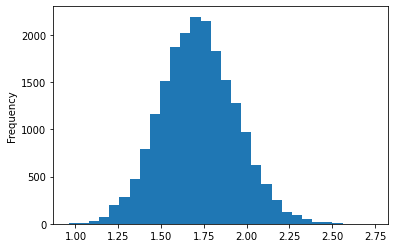

In [17]:
clust_fpt['loss'].plot.hist(bins=30);

In [18]:
clust_fpt['loss'].describe()

count    20000.000000
mean         1.718814
std          0.219484
min          0.960370
25%          1.568950
50%          1.714628
75%          1.863729
max          2.738020
Name: loss, dtype: float64

# Clustring by encoder features

## Linkage and dendogram

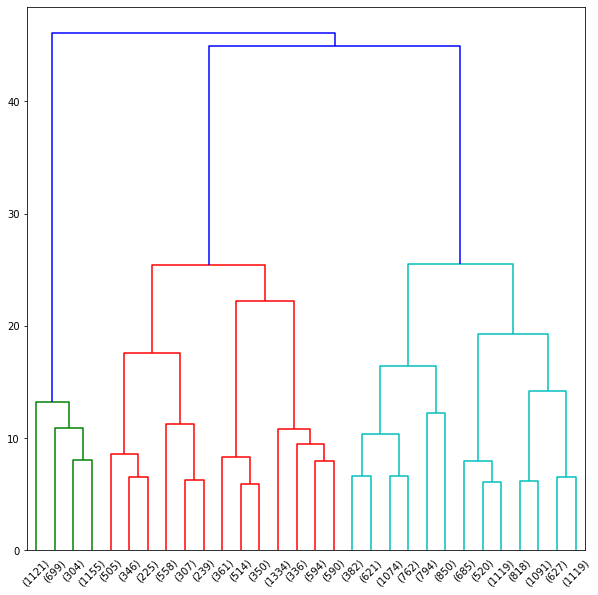

In [19]:
s_Z = linkage(enc_features, method='ward', metric='euclidean')

plt.figure(figsize=(10, 10))
s_dn = dendrogram(s_Z, color_threshold=29, truncate_mode='lastp', distance_sort=False)

## Clustering based on linkeage

In [20]:
s_cluster = fcluster(s_Z, t=29, criterion='distance')
s_unique, s_counts = np.unique(s_cluster, return_counts=True)
print(np.asarray((s_unique, s_counts)).T)
print(sum(s_counts))

[[    1  3279]
 [    2  6259]
 [    3 10462]]
20000


In [21]:
color_map = {1: 'Green', 2 : 'Red', 3 : 'Blue', 4 : 'MediumPurple'}

In [22]:
clust_fpt['AutoEnc'] = s_cluster
enc_features['AutoEnc'] = s_cluster

## Ploting the clusters

In [23]:
import plotly.express as px

fig = px.scatter_3d(enc_features, x='X1', y='X2', z='X3', color='AutoEnc', width=1500, height=1000, color_discrete_map = color_map)
fig.update_traces(marker=dict(size=1.75))
fig.show()

Saving plot as html

In [24]:
fig.write_html("MyAmazingGrph.html")

# Interpreting inter-clusters variations  by backward classification

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.model_selection import train_test_split, GridSearchCV
# cross validation:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



## Defining functions for later use

In [26]:
def visualize_tree(model, md=5, width=800):
    dot_data = StringIO()  
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, class_names = True ,special_characters=True,filled=True, max_depth=md)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
    return Image(graph.create_png(), width=width)

def print_dot_text(model, md=5):
    dot_data = StringIO()
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, max_depth=md)
    dot_text = dot_data.getvalue()
    print(dot_text)


## working with clust_fpt dataframe:

In [27]:
X = clust_fpt.drop(['AutoEnc','loss'], axis=1)
y = clust_fpt.AutoEnc

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,test_size=0.20,shuffle=True, stratify=clust_fpt.AutoEnc)

### CV method

In [28]:
my_cv = StratifiedShuffleSplit(n_splits=10, train_size=0.8, test_size=0.2)

## Grid search parameters

In [29]:
my_param_grid = {'min_samples_leaf': [1,10,20, 40,100],
                 'min_weight_fraction_leaf': [ 0.005 ,0.01 ,0.1],
                 'criterion': ['gini', 'entropy'], 
                 'max_depth':[5, 7,10,15]}

## Defining DT and training model

In [30]:
dt_model= DecisionTreeClassifier()
dt_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [31]:
dt_model_gs = GridSearchCV(estimator=dt_model, 
                           param_grid=my_param_grid, 
                           cv=my_cv, 
                           scoring='neg_log_loss')

dt_model_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.2,
            train_size=0.8),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             

In [32]:
print("Best parameters:", dt_model_gs.best_params_)

Best parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 100, 'min_weight_fraction_leaf': 0.005}


In [33]:
dt_model_1 = dt_model_gs.best_estimator_

## Applying CV

In [34]:
-cross_val_score(dt_model_1, X_train, y_train, cv=my_cv, scoring='neg_log_loss')

array([0.45994522, 0.49211961, 0.46173107, 0.45207573, 0.48338343,
       0.50012078, 0.46551761, 0.51115188, 0.5005494 , 0.47579525])

## Visualize tree and feature importance

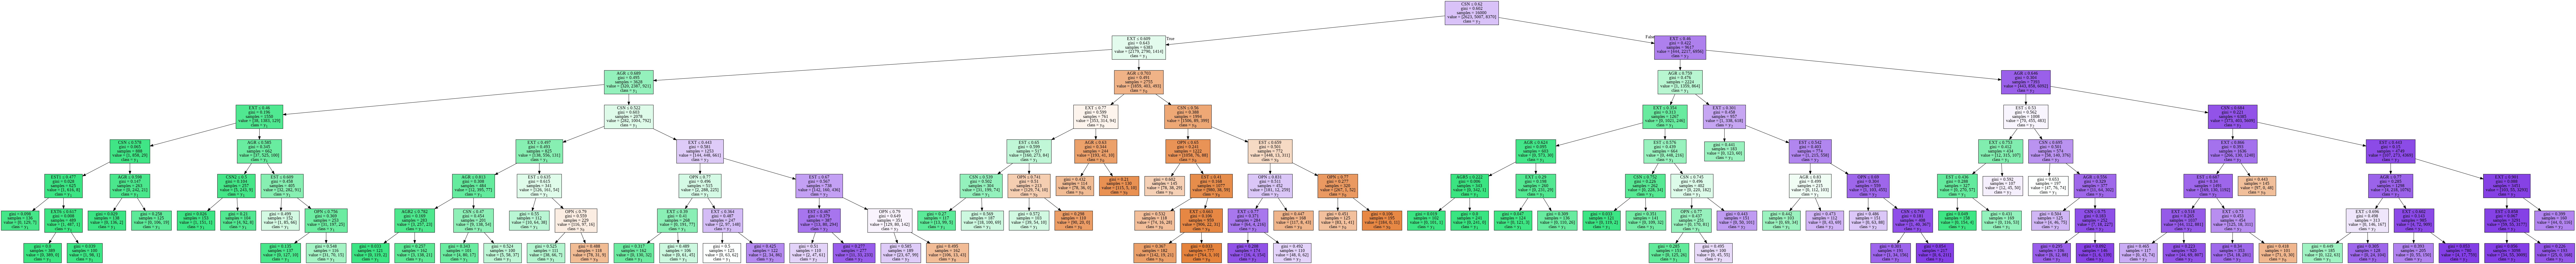

In [35]:
visualize_tree(dt_model_1, md=20, width=1200)

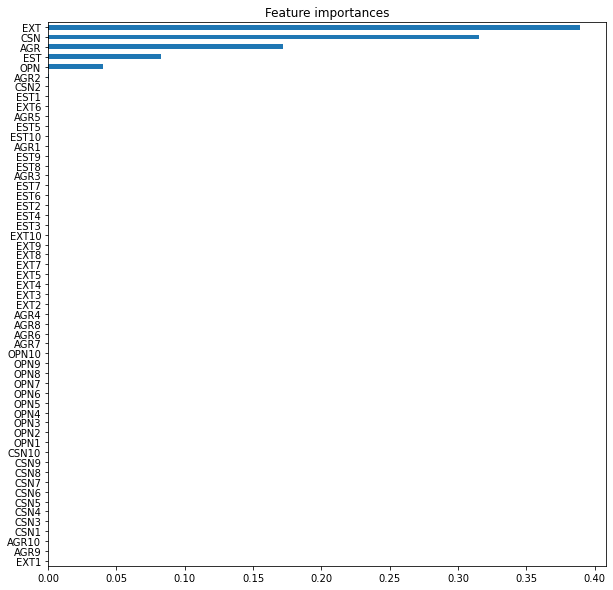

In [36]:
pd.Series(dt_model_1.feature_importances_, index=X_train.columns).sort_values()\
    .plot.barh(figsize=(10, 10), rot=0, title='Feature importances')

In [37]:
y_train_pred = pd.DataFrame(dt_model_1.predict_proba(X_train), columns=dt_model_1.classes_)

In [38]:
cm = confusion_matrix(y_true=y_train, y_pred=dt_model_1.predict(X_train))
print (cm)

[[2077  215  331]
 [ 190 4001  816]
 [ 323  852 7195]]


In [39]:
log_loss(y_train, y_train_pred)

0.41146690920620693

## DT model validation

In [40]:
y_test_pred = pd.DataFrame(dt_model_1.predict_proba(X_test), 
                        columns=dt_model_1.classes_)
log_loss(y_test, y_test_pred)

0.4757718581404704

### According to DT classifier the most important features in classification to auto-encoder's clusters are: 
1. EXT
2. EST
3. OPN

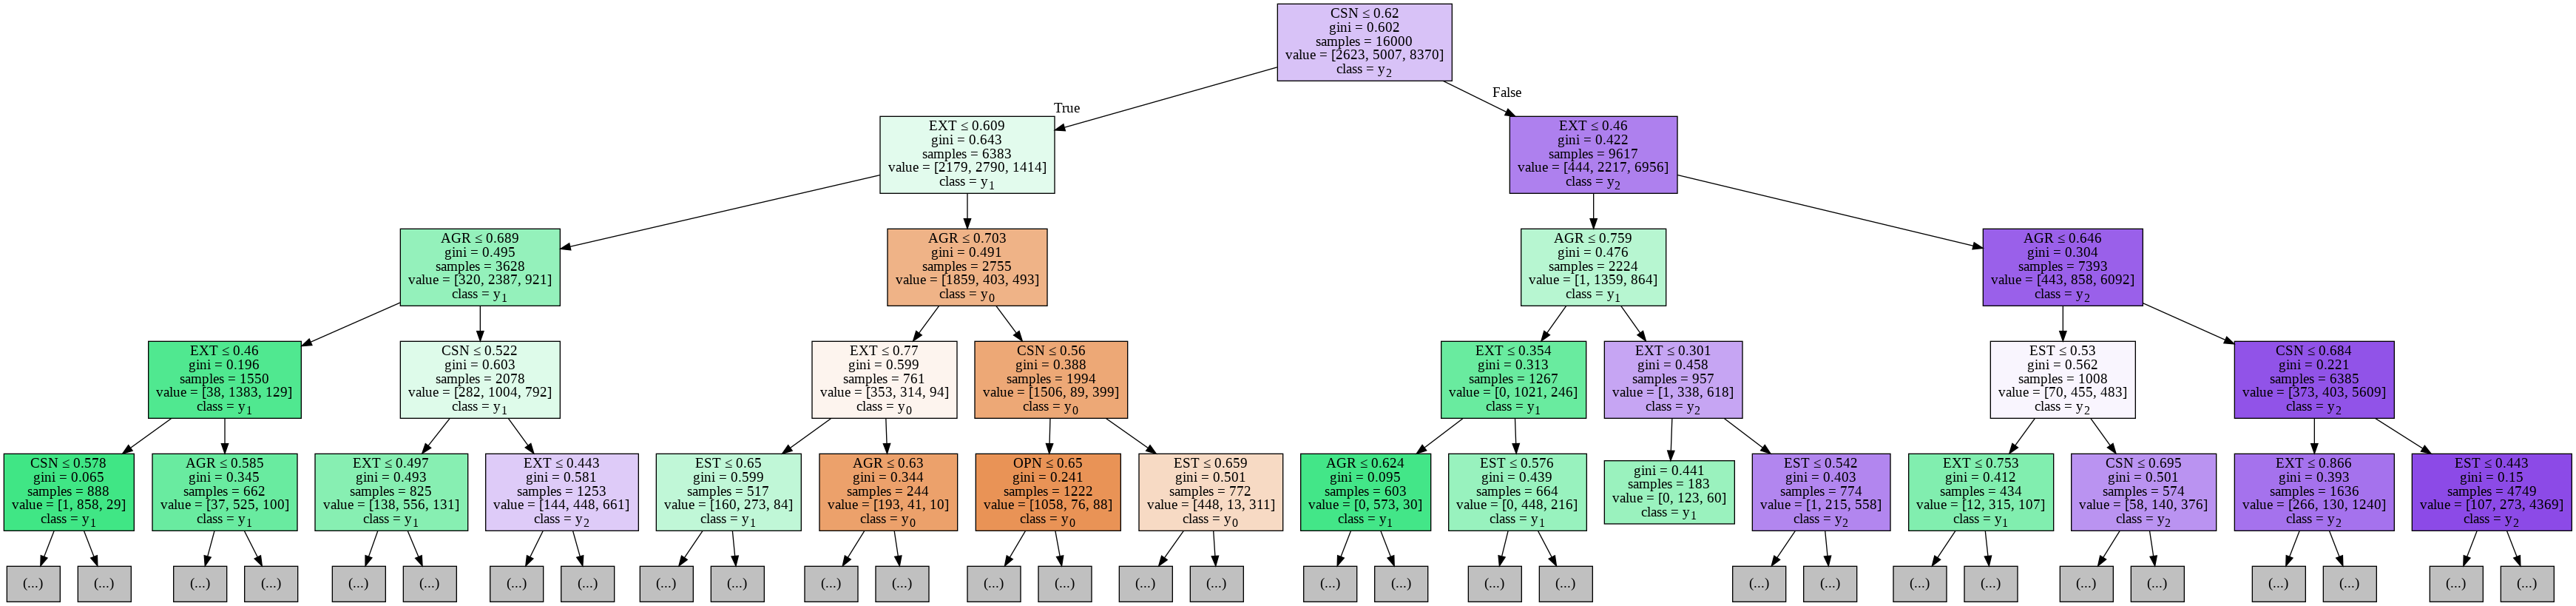

In [41]:
visualize_tree(dt_model_1, md=4, width=600)

In [42]:
import plotly.express as px

fig = px.scatter_3d(clust_fpt, x='EST', y='CSN', z='AGR', color='AutoEnc', width=1500, height=1000, color_discrete_map = color_map)
fig.update_traces(marker=dict(size=1.75))
fig.show()

## Grouping clusters by axes means

In [43]:
grouped = clust_fpt.groupby('AutoEnc').agg(
    EXT_mean=('EXT', np.mean),
    OPN_mean=('OPN', np.mean),
    CSN_mean=('CSN', np.mean),
    AGR_mean=('AGR', np.mean),
    EST_mean=('EST', np.mean)).reset_index()

grouped

,AutoEnc,EXT_mean,OPN_mean,CSN_mean,AGR_mean,EST_mean
0,1,0.762820,0.833474,0.544262,0.802480,0.682320
1,2,0.443891,0.746026,0.615040,0.645485,0.607446
2,3,0.627171,0.772737,0.739651,0.807293,0.591016


In [49]:
import plotly.graph_objects as go
categories = ['Extroversion', 'Openness', 'Conscientiousness', 'Agreeableness', 'Neuroticism']
fig =  go.Figure()

layout = dict(radialaxis=dict(visible=True, range=[0,1]))

for (_, cluster, col0, col1, col2, col3, col4) in grouped.itertuples(name=None):
    fig.add_trace(go.Scatterpolargl(r=[col0, col1, col2, col3, col4], theta=categories, name=f'cluster {cluster}'))
          
fig.update_layout(polar1=layout, showlegend=True, height=700, width=700)
fig.show()